In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib as mpl
import pickle
from copy import copy
from tqdm import tqdm_notebook as tqdm
from importlib import reload

import readdy_learn.example.mapk as mapk

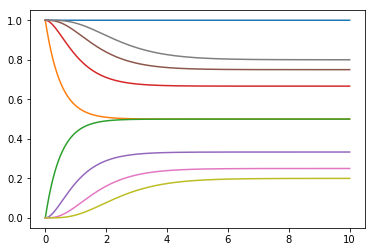

In [2]:
mapk.TIMESTEP = 1e-3
mapk.N_STIMULUS = 1
mapk.INITIAL_STATES[0][0] = mapk.N_STIMULUS
cfg = mapk.MAPKConfiguration()
time, count, dcount_dt = mapk.generate_lma(10, cfg)

plt.plot(time, count)
plt.show()

In [16]:
activities = []
X = np.logspace(-3, 3, num=100)
for N_STIMULUS in tqdm(X):
    mapk.TIMESTEP = 1e-3
    mapk.INITIAL_STATES[0][0] = N_STIMULUS
    time, count, dcount_dt = mapk.generate_lma(10, cfg)
    activities.append(count[-1, -1])
mapk.TIMESTEP = 1e-3
mapk.N_STIMULUS = 1
mapk.INITIAL_STATES[0][0] = mapk.N_STIMULUS
cfg = mapk.MAPKConfiguration()

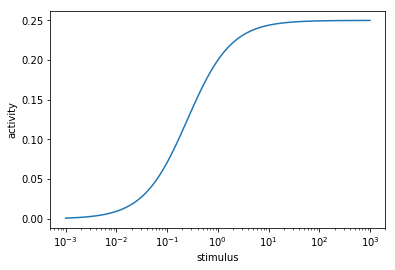

In [17]:
plt.semilogx(X, activities)
plt.xlabel('stimulus')
plt.ylabel('activity')
plt.show()

In [3]:
mapk=reload(mapk)
cfg = mapk.MAPKConfiguration()

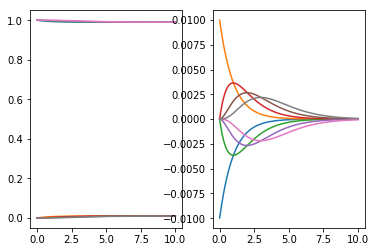

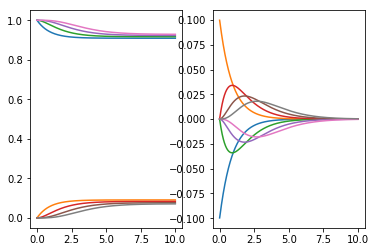

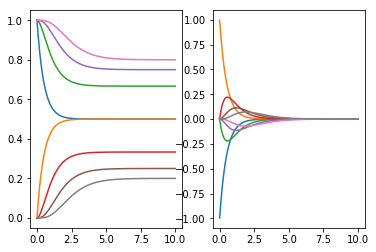

In [10]:
data = []
for N_STIMULUS in [1e-2, 1e-1, 1e0]:
    # mapk.TIMESTEP = 3e-2 # works well
    mapk.TIMESTEP = 5e-3 # 2.7 works better
    
    X = copy(mapk.INITIAL_STATES)
    X[0][0] = N_STIMULUS
    mapk.INITIAL_STATES = X
    time, count, dcount_dt = mapk.generate_lma(1, cfg)
    # time, count, dcount_dt = mapk.generate_kmc(0, .003, n_realizations=15, njobs=5)
    data.append((time, count, dcount_dt))
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(time, count[:, 1:])
    ax2.plot(time, dcount_dt[:, 1:])
    # plt.plot(time, count[:, 1:])
    f.show()

In [5]:
time = np.concatenate([data[i][0] for i in range(len(data))])
counts = np.concatenate([data[i][1] for i in range(len(data))])
dcounts_dt = np.concatenate([data[i][2] for i in range(len(data))])

# shuffle
N = np.arange(len(time))
np.random.shuffle(N)
shuffled_time = time[N]
shuffled_counts = counts[N]
shuffled_dcounts_dt = dcounts_dt[N]

In [6]:
len(time)

600

In [316]:
result = mapk.solve_grid(cfg, shuffled_counts, shuffled_dcounts_dt, l1_ratios=(1.,), 
                         alphas=np.logspace(-10, -6, num=100), njobs=6)

Trying tolerance 1e-16
Trying tolerance 1e-16
Trying tolerance 1e-16
Trying tolerance 1e-16
Trying tolerance 1e-16
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.3219411484660286e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
155 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0974987654930546e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
178 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.747528400007683e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
157 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.2045035402587836e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
175 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
173 / 5000 iterations
Try

optimization problem did exit successfully (alpha=5.994842503189421e-09, lambda=1.0)!
status 0: Optimization terminated successfully.
299 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=6.579332246575682e-09, lambda=1.0)!
status 0: Optimization terminated successfully.
286 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=8.697490026177834e-09, lambda=1.0)!
status 0: Optimization terminated successfully.
289 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=7.924828983539185e-09, lambda=1.0)!
status 0: Optimization terminated successfully.
325 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=9.545484566618328e-09, lambda=1.0)!
status 0: Optimization terminated successfully.
293 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0476157527896662e-08, lambda=1.0)!
status 0: Optimiza

194 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=4.7508101621027934e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
199 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=5.214008287999695e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
193 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=5.722367659350221e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
191 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=7.564633275546291e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
166 / 5000 iterations
optimization problem did exit successfully (alpha=6.28029144183426e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
188 / 5000 iterations
optimization problem did exit successfully (alpha=6.892612104349709e-07, lambda=1.0)!
status 0: Optimizati

In [317]:
alphas = np.array([res[0] for res in result])
sort = np.argsort(alphas)
alphas = alphas[sort]
estimated_rates = np.array([res[2] for res in result])
estimated_rates = estimated_rates[sort]
l1_errs = np.sum(np.abs(estimated_rates - cfg.rates), axis=1)

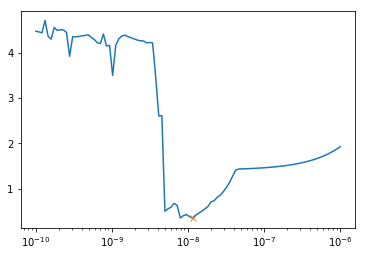

In [318]:
plt.semilogx(alphas, l1_errs)
plt.plot([alphas[np.argmin(l1_errs)]], [l1_errs[np.argmin(l1_errs)]], 'x')

In [319]:
alphas[np.argmin(l1_errs)]

1.1497569953977357e-08

In [320]:
best_estimated_rates = estimated_rates[np.argmin(l1_errs)]

In [321]:
np.abs(((estimated_rates[0][:8] - cfg.rates[:8]) / cfg.rates[:8]))

array([1.49007924e-04, 3.28124662e-04, 7.27035912e-05, 3.32464078e-01,
       1.02908956e-03, 5.53466269e-01, 5.62911893e-03, 7.13389883e-01])

In [322]:
np.abs(((best_estimated_rates[:8] - cfg.rates[:8]) / cfg.rates[:8]))

array([1.49330683e-04, 3.28942542e-04, 1.04755297e-04, 6.95138923e-04,
       1.61833285e-03, 3.44642362e-03, 9.12899797e-02, 2.44987155e-01])

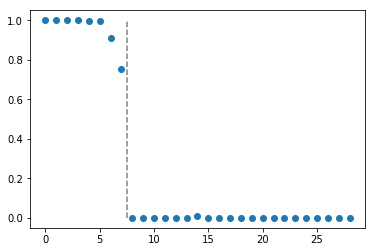

In [323]:
plt.plot(best_estimated_rates, 'o')
plt.vlines([7.5], 0, 1, 'grey', 'dashed')

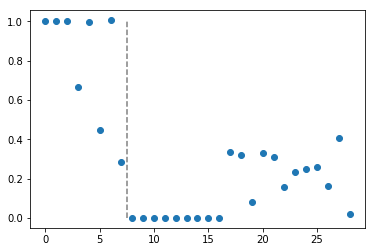

In [324]:
plt.plot(estimated_rates[0], 'o')
plt.vlines([7.5], 0, 1, 'grey', 'dashed')

In [8]:
cv_result = mapk.cv(cfg, shuffled_counts, shuffled_dcounts_dt, 
                    alphas=np.logspace(-9.5, -7.5, 40), n_splits=15, njobs=8)

validating across grid with 40 alphas, 1 lambdas, 1 cutoffs with 1 realizations


Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16


Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/mho/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Process ForkPoolWorker-7:
  File "/home/mho/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-5:
  File "/home/mho/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/multiprocess/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
Process ForkPoolWorker-4:
  File "/home/mho/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mho/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mho/Developm

KeyboardInterrupt: 

In [51]:
s_nonrel = []
for estimated_rates in estimated_rateses:
    #print(estimated_rates[:8] - mapk.RATES[:8])
    #print("***"*15)
    s_nonrel.append(np.sum(np.abs(((estimated_rates[:8] - mapk.RATES[:8]) ))))

In [52]:
s = []
for estimated_rates in estimated_rateses:
    #print((estimated_rates[:8] - mapk.RATES[:8]) / mapk.RATES[:8])
    #print("***"*15)
    s.append(np.max(np.abs(((estimated_rates[:8] - mapk.RATES[:8]) / mapk.RATES[:8]))))

In [53]:
plt.semilogy(np.arange(1, len(s)+1), s, 'x')
#plt.plot(np.arange(1, len(s)+1), s_nonrel, 'o')
plt.xticks(np.arange(1, len(s)+1))
plt.hlines([1.], 1, len(s))
# plt.vlines(np.arange(1, len(s)+1), 0, 1e3, 'grey', 'dashed')

np.abs(((estimated_rateses[0][:8] - mapk.RATES[:8]) / mapk.RATES[:8]))

In [79]:
cv_result = mapk.cv(shuffled_counts, shuffled_dcounts_dt, l1_ratios=(1.,), alphas=np.logspace(2.5, 4, num=25), 
                    n_splits=15, njobs=6)

validating across grid with 25 alphas, 1 lambdas, 1 cutoffs with 1 realizations


Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for toleranc

Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for tolerance 1e-16
Solving for toleranc

In [80]:
alphas = []
scores = []
for res in cv_result['cv_result']:
    alphas.append(res['alpha'])
    scores.append(np.mean(res['score']))
alphas = np.array(alphas)
scores = np.array(scores)
N = np.argsort(alphas)
alphas = alphas[N]
scores = scores[N]

In [81]:
%matplotlib qt
plt.semilogx(alphas, -scores)
#plt.ylim([4.447e8, 4.46e8])

In [84]:
X = np.argmin(-scores)

In [85]:
alphas[X]

421.6965034285823

In [86]:
bfc =mapk.bfc()
mapk.bogus_bfc(bfc)

8

In [87]:
RATES = np.array([
    1.,
    1000.,
    1.,
    1000.,
    1.,
    1000.,
    1.,
    1000.,
])
mapk.RATES = np.concatenate((RATES, np.zeros((mapk.N_BOGUS,))))

In [88]:
estimated_rates = mapk.solve(counts, dcounts_dt, alpha=alphas[X], l1_ratio=1.)

Trying tolerance 1e-16
optimization problem did exit successfully (alpha=421.6965034285823, lambda=1.0)!
status 0: Optimization terminated successfully.
22 / 30000 iterations


In [89]:
-np.sort(-np.abs(((estimated_rates[:8] - mapk.RATES[:8]) / mapk.RATES[:8])))

array([0.27721306, 0.01050332, 0.00862906, 0.00404381, 0.00292371,
       0.00057347, 0.00054221, 0.0003029 ])

In [90]:
estimated_rates = mapk.solve(counts, dcounts_dt, alpha=0, l1_ratio=1.)

Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0, lambda=1.0)!
status 0: Optimization terminated successfully.
21 / 30000 iterations


In [91]:
-np.sort(-np.abs(((estimated_rates[:8] - mapk.RATES[:8]) / mapk.RATES[:8])))

array([2.49018679e-01, 1.05021623e-02, 8.62863328e-03, 5.54867604e-04,
       5.29518123e-04, 1.11964732e-04, 7.39761643e-05, 1.30372199e-05])

In [16]:
estimated_rates

array([ 9.91371044e-01,  9.89496972e+02,  9.99455822e-01,  9.99206189e+02,
        7.67234265e-01,  9.75547750e+02,  7.56833775e-01,  5.78850166e+02,
        2.37761448e-04,  2.37981604e-01,  2.01302884e-01,  2.37490330e-01,
        2.04182798e-01, -2.37920287e-01,  2.03394233e-01,  1.69219547e-01,
       -4.04724344e-01,  1.24116303e-03, -2.11668765e-02, -4.17673185e-02,
        5.90881176e-02, -4.82711869e-01,  1.18363528e+00])

In [53]:
tuples = tuple((i, j) for i in range(1, 9) for j in range(9) if j > i)

In [54]:
pairs = tuple((tuples[i], tuples[j]) for i in range(len(tuples)) for j in range(len(tuples)) if j != i
             and tuples[i][0] == tuples[j][0] and tuples[i][1] - tuples[j][1] == -1 and tuples[i][1] % 2 == 1)

In [55]:
pairs = [(pairs[i][0], pairs[i][1]) for i in range(len(pairs))] 
        + [(pairs[i][1], pairs[i][0]) for i in range(len(pairs))]

In [56]:
pairs

[((1, 3), (1, 4)),
 ((1, 5), (1, 6)),
 ((1, 7), (1, 8)),
 ((2, 3), (2, 4)),
 ((2, 5), (2, 6)),
 ((2, 7), (2, 8)),
 ((3, 5), (3, 6)),
 ((3, 7), (3, 8)),
 ((4, 5), (4, 6)),
 ((4, 7), (4, 8)),
 ((5, 7), (5, 8)),
 ((6, 7), (6, 8)),
 ((1, 4), (1, 3)),
 ((1, 6), (1, 5)),
 ((1, 8), (1, 7)),
 ((2, 4), (2, 3)),
 ((2, 6), (2, 5)),
 ((2, 8), (2, 7)),
 ((3, 6), (3, 5)),
 ((3, 8), (3, 7)),
 ((4, 6), (4, 5)),
 ((4, 8), (4, 7)),
 ((5, 8), (5, 7)),
 ((6, 8), (6, 7))]